# Handin 5 Neo4J Python connection
*By: Frederik Dinsen, Frederik Dahl, Josef Pedersen, Sebastian Bentley*

Connection to neo4j database from python

#### Credentials
    username: neo4j 
    password: test

In [1]:
# Install driver 
!pip install neo4j

In [2]:
from neo4j import GraphDatabase
import pandas as pd

Importing data from the CSV file in sample data sample_game1

[Link to the github repo](https://github.com/metrica-sports/sample-data)

In [3]:
url = 'https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv'
sportevents = pd.read_csv(url, delimiter = ',')
sportevents.head(10)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,Away,PASS,NaN,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
6,Away,PASS,NaN,1,279,11.16,303,12.12,Player22,Player17,0.39,0.96,0.49,0.98
7,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,Player17,NaN,0.51,0.97,0.27,0.75
8,Home,RECOVERY,INTERCEPTION,1,378,15.12,378,15.12,Player2,NaN,0.27,0.78,NaN,NaN
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,Player2,NaN,0.27,0.78,0.59,0.64


In [4]:
sportevents.describe() 

,Period,Start Frame,Start Time [s],End Frame,End Time [s],Start X,Start Y,End X,End Y
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1664.000000,1664.000000,1109.000000,1109.000000
mean,1.488825,70503.382235,2820.135289,70526.925501,2821.077020,0.527139,0.502524,0.524454,0.503201
std,0.500018,41925.812208,1677.032488,41925.545286,1677.021811,0.243625,0.283635,0.242372,0.299590
min,1.000000,1.000000,0.040000,0.000000,0.000000,0.000000,-0.020000,-0.050000,-0.040000
25%,1.000000,32338.000000,1293.520000,32338.000000,1293.520000,0.360000,0.270000,0.350000,0.250000
50%,1.000000,68920.000000,2756.800000,68945.000000,2757.800000,0.530000,0.490000,0.530000,0.490000
75%,2.000000,107787.000000,4311.480000,107802.000000,4312.080000,0.702500,0.752500,0.690000,0.780000
max,2.000000,143622.000000,5744.880000,143630.000000,5745.200000,1.010000,1.010000,1.060000,1.040000


#### Creating query string 
Query that will export the data to Neo4j = create nodes, no features

In [5]:
 query_string = '''
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv"
    AS line FIELDTERMINATOR ','
    CREATE (:Sportevent {Type: line.Type, Subtype: coalesce(line.Subtype, "NULL"), Id: linenumber(), Period: line.Period}) 
    MERGE (p1:Player {Team: line.Team, Player: line.From})
    MERGE (p2:Player {Team: line.Team, Player: line.To})
    '''

#### Creating a connection class

In [6]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)      
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
    def close(self):
        if self.__driver is not None:
            self.__driver.close() 

#### Connect to Neo4j

In [7]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="test")

#### Creating database
Creating or replacing the database. Just like mySQL
Setting constraints on database

In [8]:
conn.query("CREATE OR REPLACE DATABASE sportevent")
conn.query("CREATE CONSTRAINT ON (n:Player) ASSERT n.Player IS UNIQUE")

Query failed: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=4, name='constraint_c21a0db3', type='UNIQUENESS', schema=(:Player {Player}), ownedIndex=3 )'.}


#### Run the querystring
Populating database with querystring with the [sample data](https://github.com/metrica-sports/sample-data)
Can be some errors since some of the data is NaN 

In [9]:
conn.query(query_string, db='sportevent')

Query failed: {code: Neo.ClientError.Statement.SemanticError} {message: Cannot merge the following node because of null property value for 'Player': (:Player {Player: null})}


#### Create relations 
First we are creating player nodes and then linking the players to the events 

In [10]:
sportevents.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47


#### Query
Query string to create nodes with relations

In [11]:
query_string = '''
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv'
    AS line FIELDTERMINATOR ','
    MATCH (from:Player {Player: line.From}),(e:Sportevent {Id: linenumber()}),(to:Player {Player: line.To})
    CREATE (from)-[:PLAYS {sf:line.`Start Frame`, st:line.`Start Time [s]`, sx:line.`Start X`, sy:line.`Start Y`}]->(e)
    CREATE (e)-[:PLAYS {ef:line.`End Frame`, et:line.`End Time [s]`, ex:line.`End X`, ey:line.`End Y`}]->(to)
    '''

In [12]:
conn.query(query_string, db='sportevent')

[]

### Investigation with Cypher 

1. Who is the most active player (in terms of passing and receiving the ball)? 

In [13]:
most_active = '''
MATCH (n:Player)-[p:PLAYS]-()
RETURN n, count(DISTINCT p) AS num
ORDER BY num DESC LIMIT 1
'''
player = conn.query(most_active, db='sportevent')
print("Most active player is: ",player[0].data())

Most active player is:  {'n': {'Player': 'Player21', 'Team': 'Away'}, 'num': 107}


2. Who has had a central role in the match?

In [14]:
central_match = '''
MATCH (n:Player)-[]->(e:Sportevent)
WHERE e.Type = 'PASS'
RETURN n, COUNT(n) AS num
ORDER BY num DESC LIMIT 5
'''
central = conn.query(central_match, db='sportevent')
print("Top 5 most central player are: ")

for item in central:
    print(item.data())

Top 5 most central player are: 
{'n': {'Player': 'Player21', 'Team': 'Away'}, 'num': 52}
{'n': {'Player': 'Player6', 'Team': 'Home'}, 'num': 48}
{'n': {'Player': 'Player12', 'Team': 'Home'}, 'num': 42}
{'n': {'Player': 'Player7', 'Team': 'Home'}, 'num': 42}
{'n': {'Player': 'Player4', 'Team': 'Home'}, 'num': 40}


3. Which players have attempted to score?

In [50]:
score_attempt = '''
MATCH (n:Player)-[]->(e:Sportevent)
WHERE e.Subtype = 'GOAL KICK'
RETURN n, COUNT(n) AS num
ORDER BY num DESC
'''
result = conn.query(score_attempt, db='sportevent')
print("Players with most score attempts are: ")

for item in result:
    print(item.data())


Players with most score attempts are: 
{'n': {'Player': 'Player25', 'Team': 'Away'}, 'num': 8}
{'n': {'Player': 'Player11', 'Team': 'Home'}, 'num': 2}


4. Which team has kept the ball longer?

In [26]:
away = '''
MATCH (p:Player)-[s1:PLAYS]->(e:Sportevent)-[s2:PLAYS]->()
WHERE p.Team = 'Away'
RETURN sum(toInteger(s2.et) - toInteger(s1.st))
'''

home = '''
MATCH (p:Player)-[s1:PLAYS]->(e:Sportevent)-[s2:PLAYS]->()
WHERE p.Team = 'Home'
RETURN sum(toInteger(s2.et) - toInteger(s1.st))
'''

result_away = conn.query(away, db='sportevent')
result_home = conn.query(home, db='sportevent')

print('Time home has had the ball: ', result_home[0].data().get('sum(toInteger(s2.et) - toInteger(s1.st))'))
print('Time away has had the ball: ', result_away[0].data().get('sum(toInteger(s2.et) - toInteger(s1.st))'))

Time home has had the ball:  502
Time away has had the ball:  412


5. Is there any close ‘societies’ between players (passing the ball to each other)? o how close is the connection between two specific players?

In [49]:
close_two_players = '''
MATCH p=shortestPath(
  (p1:Player {Player:"Player19"})-[*]-(p2:Player {Player:"Player21"})
)
RETURN p
'''

result2 = conn.query(close_two_players, db='sportevent')
print('Closeness between player 19 and player 21 is:', len(result2[0].values()[0]))

Closeness between player 19 and player 21 is: 2


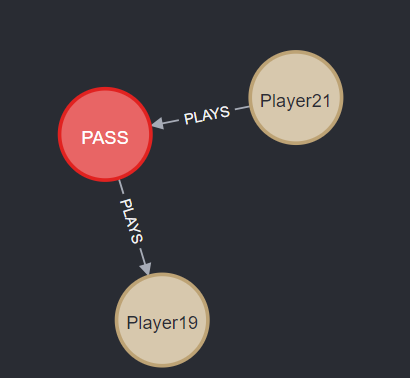

### Graph visualization
Use graph visualization as much as appropriate

#### Visualization of our database pre implementation   
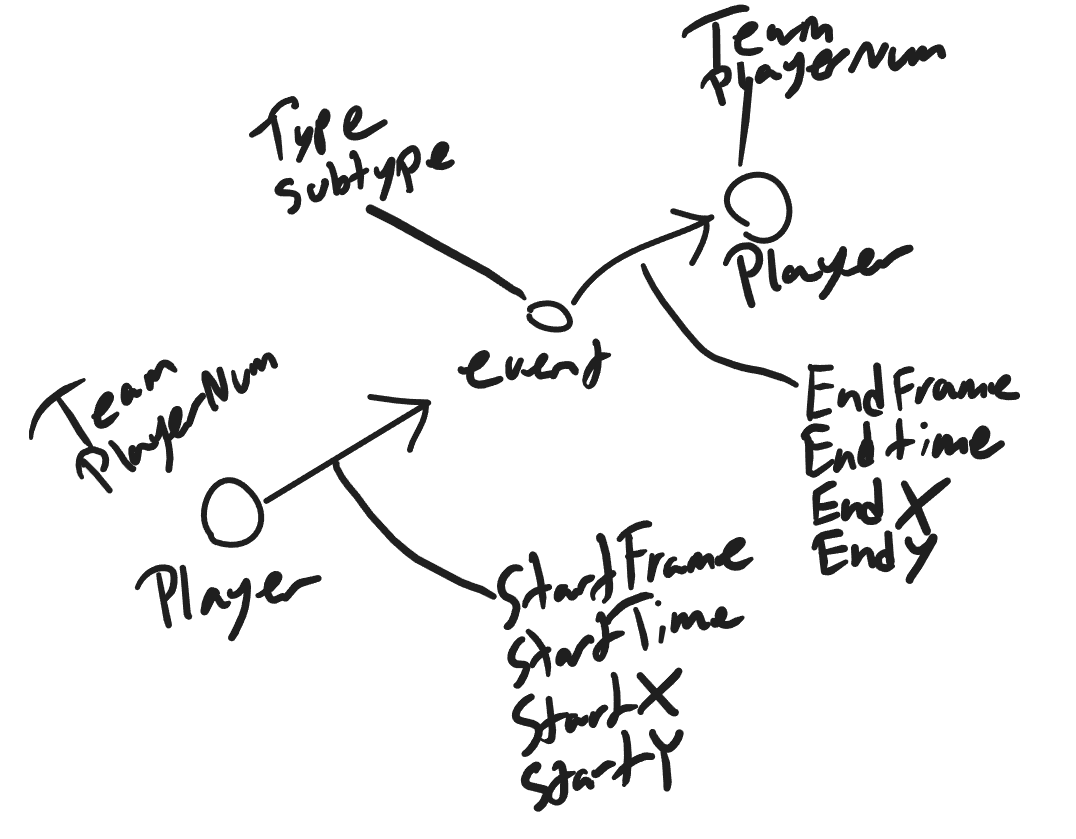




#### Visualization of our database implementation 
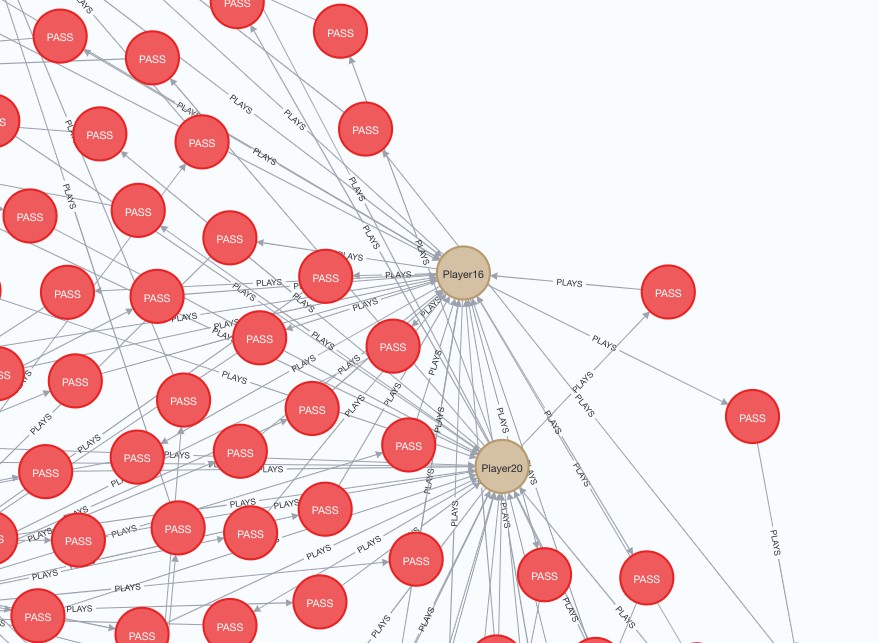